## Requirements

Example
- Lets assume you are going to use still photographs comming from a RGB camera.

- You have some **computing power** onboard the device and want to use that to do the processing. No connection to internet. the computing power is equal to a modern phone.

- What sort of **performance** are we after?

- **Data**: how to obtain data, how much and what type?

## Package imports

In [2]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

2025-09-01 01:23:28.448209: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-01 01:23:28.464304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-01 01:23:28.488961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-01 01:23:28.488987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-01 01:23:28.503988: I tensorflow/core/platform/cpu_feature_gua

## Import and preprocess data 

In [3]:
dev_labels = pd.read_csv("../dev_data_2025.csv")
future_labels = pd.read_csv("../future_data_2025.csv")

In [4]:
dev_labels

,imageID,label,cell_shape,nucleus_shape,cytoplasm_vacuole
0,Img_00001,Lymphocyte,round,unsegmented-round,no
1,Img_00002,Monocyte,irregular,unsegmented-indented,no
2,Img_00003,Monocyte,irregular,irregular,yes
3,Img_00004,Basophil,round,segmented-multilobed,no
4,Img_00005,Neutrophil,round,unsegmented-band,no
...,...,...,...,...,...
4995,Img_04996,Lymphocyte,irregular,unsegmented-round,no
4996,Img_04997,Neutrophil,round,unsegmented-band,no
4997,Img_04998,Basophil,round,irregular,no
4998,Img_04999,Neutrophil,round,unsegmented-band,no


In [5]:
# convert to integers while saving the mapping in label_vocab
TARGETS = ["label", "cell_shape", "nucleus_shape", "cytoplasm_vacuole"]
target_vocab = {}
for target in TARGETS:
    dev_labels[target], target_vocab[target] = pd.factorize(dev_labels[target])
dev_labels

,imageID,label,cell_shape,nucleus_shape,cytoplasm_vacuole
0,Img_00001,0,0,0,0
1,Img_00002,1,1,1,0
2,Img_00003,1,1,2,1
3,Img_00004,2,0,3,0
4,Img_00005,3,0,4,0
...,...,...,...,...,...
4995,Img_04996,0,1,0,0
4996,Img_04997,3,0,4,0
4997,Img_04998,2,0,2,0
4998,Img_04999,3,0,4,0


In [6]:
# make train test split
from sklearn.model_selection import train_test_split

train_data_df, test_data_df = train_test_split(dev_labels, test_size=0.2, stratify=dev_labels["label"], random_state=42)
train_data_df, val_data_df = train_test_split(train_data_df, test_size=0.25, stratify=train_data_df["label"], random_state=42)

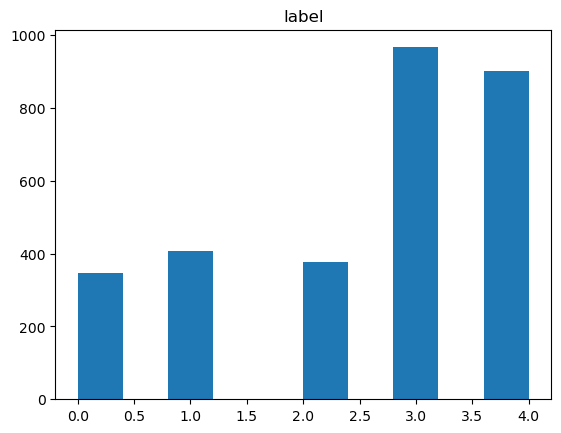

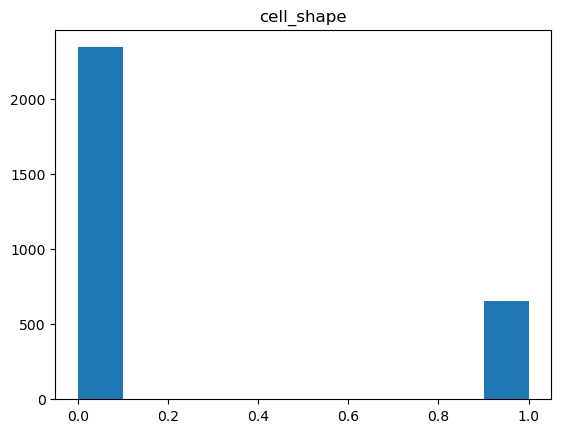

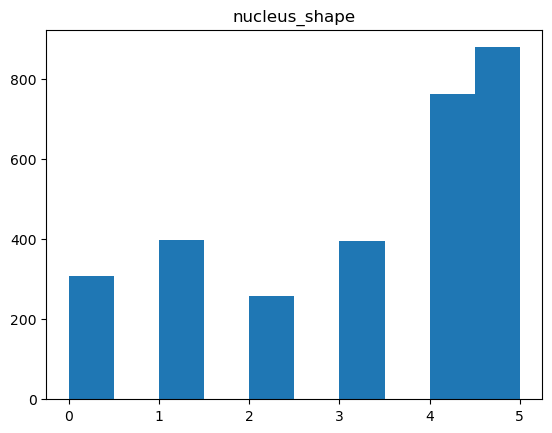

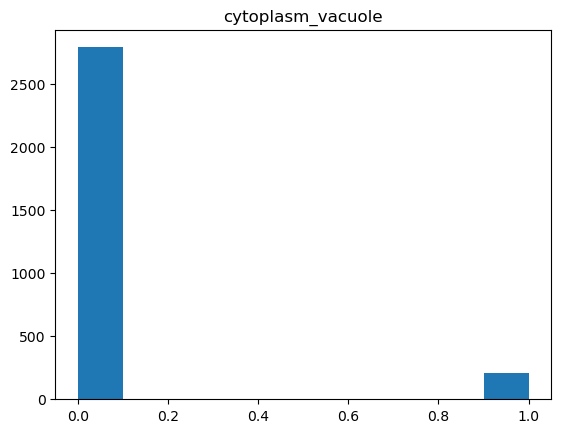

In [7]:
for target in TARGETS:
    plt.hist(train_data_df[target])
    plt.title(target)
    plt.show()

**Observation**: 
- All targets have imbalanced classes and it is especially severe for "cell shape" and "cytoplasm vacuole".
- Because "nucleus shape" has 6 classes, some classes are represented by few training samples.

**Solutions**:
- **Oversampling**: works well for single-output models or multi-output models where one output is significantly more important than the others, as the upsampling aims to balance the classes in a specific output.
- **Augmention**: can be done more extensively on underrepresented classes. It does, however, have some of the same issues as oversampling. Normal, uniform augmentation does not solve the imbalance issue but it does increase the absolute number of samples in the underrepresented classes.
- **Per-class weighting**: can be done seperately for each output (unlike oversampling and augmentation), which makes advantages for imbalanced multi-output models.
- **Robust performance metric**: towards imbalanced classes. 

Based on these considerations, normal augmentation is applied as well as per-class weighting and using F1 as the performance metric rather than accuracy.

In [8]:
def make_class_weights(series):
    # count number of each label
    counts = series.value_counts().sort_index().to_numpy()
    # use inverse frequency to give higher weight to infrequent classes
    weights = counts.sum() / (len(counts) * counts)
    return tf.constant(weights)

weight_dict = {target: make_class_weights(train_data_df[target]) for target in TARGETS}


2025-09-01 01:23:32.816962: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-01 01:23:32.866459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-01 01:23:32.869532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
from pathlib import Path

IMG_DIR = "../Hematoxylin"

def load_image(image_path: str, target_dict: dict):
    full_path = tf.strings.join([IMG_DIR, "/", image_path, ".jpg"])
    image = tf.io.read_file(full_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [32, 32])
    image = tf.image.grayscale_to_rgb(image) # ResNet requires rgb

    # one-hot encode each output
    target_onehot_dict = {target: tf.one_hot(vals, len(target_vocab[target])) for target, vals in target_dict.items()}

    return image, target_onehot_dict

def add_sample_weights(image, target_onehot_dict: dict):
    # get class ids
    class_ids = {target: tf.argmax(vals, axis=-1) for target, vals in target_onehot_dict.items()}
    sample_weights = {target: tf.gather(weight_dict[target], class_ids[target]) for target in target_onehot_dict}
    
    return image, target_onehot_dict, sample_weights

def create_tf_dataset_from_df(df: pd.DataFrame, train_data = False):
    ds = tf.data.Dataset.from_tensor_slices((
        df['imageID'].values,
        {target: df[target].values for target in TARGETS},
    ))
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    if train_data:
        ds = ds.map(add_sample_weights, num_parallel_calls=AUTOTUNE)

    return ds

train_dataset = create_tf_dataset_from_df(train_data_df, train_data = True)
val_dataset = create_tf_dataset_from_df(val_data_df)
test_dataset = create_tf_dataset_from_df(test_data_df)

In [10]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_dataset))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(val_dataset)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_dataset))

Number of training samples: 3000
Number of validation samples: 1000
Number of test samples: 1000


**Observation:**
Training is relatively small, which means limited fine tuning of backbone model can be performed later. The training set is not found to be too small for some degree of fine tuning. 

In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_batches = (
    train_dataset
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

validation_batches = (
    val_dataset
    .batch(BATCH_SIZE)
)

test_batches = (
    test_dataset
    .batch(BATCH_SIZE)
)

Print the shapes of the output tensor to check if the dataset generation is working.

In [12]:
for image, targets, weights in train_batches.take(5):
    print(image.shape, [target.shape for _,target in targets.items()])

for image, targets in validation_batches.take(5):
    print(image.shape, [target.shape for _,target in targets.items()])

for image, targets in test_batches.take(5):
    print(image.shape, [target.shape for _,target in targets.items()])


(32, 32, 32, 3) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 3) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 3) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 3) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 3) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 3) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 3) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 3) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 3) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 3) [TensorShape([32, 5]), TensorShape([32,

2025-09-01 01:23:40.732054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-01 01:23:40.803013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-01 01:23:40.861386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-09-01 01:23:45.888541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


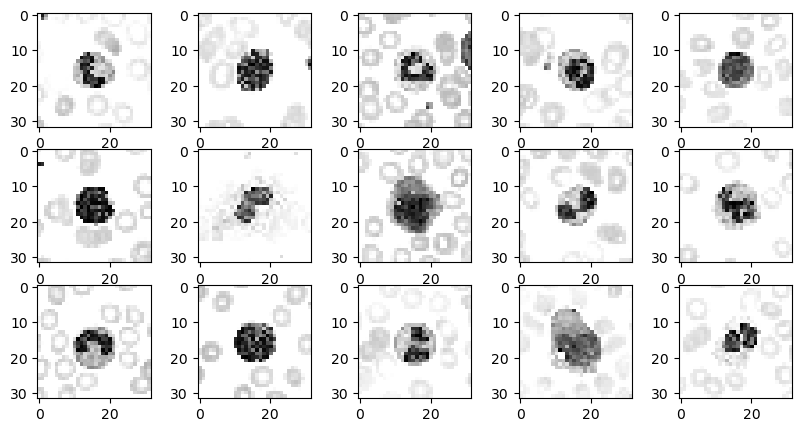

In [13]:
plt.figure(figsize=(10,5))
# clabel = {0: 'right', 1: 'left', 2: 'down', 3: 'up'}
i = 1
for image, targets, weights in train_batches.take(15):
    plt.subplot(3,5,i)
    plt.imshow(image[0,:,:,0], cmap='gray')
    # plt.title(str(clabel[np.argmax(label[0,:])]))
    i = i+1

**Observation:** cells seem to always be in the center and orientation is not important. Hence, tilting with large angles is possible. All examined images seem to be representative for the application.

## Model development

In [15]:
IMG_SIZE = (32, 32)
IMG_SHAPE = (32, 32, 3)


In [19]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

base_model = tf.keras.applications.ResNet50(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)
base_model.trainable = False

data_augmentation = tf.keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomRotation(0.1),]
)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = {target: tf.keras.layers.Dense(len(target_vocab[target]), activation='softmax')(x) for target in TARGETS}
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 tf.__operators__.getitem_1  (None, 32, 32, 3)            0         ['input_6[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.nn.bias_add_1 (TFOpLamb  (None, 32, 32, 3)            0         ['tf.__operators__.getitem_1[0
 da)                                                                ][0]']                        
                                                                                            

In [ ]:
m_histories = {}

In [22]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=METRICS,
)

epochs = 5
m_histories['baseModel'] =  model.fit(train_batches,
                                        epochs=epochs,
                                        validation_data=validation_batches,
                                        # callbacks=get_callbacks('models/baseModel')
                                        )

Epoch 1/5


2025-09-01 01:40:08.215847: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1756690820.327090   20494 service.cc:145] XLA service 0x7f2874147220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756690820.327137   20494 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-09-01 01:40:20.479656: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/94 [..............................] - ETA: 1:07:47 - loss: 7.6801 - dense_5_loss: 0.7918 - dense_7_loss: 1.0361 - dense_4_loss: 2.7984 - dense_6_loss: 3.0538 - dense_5_accuracy: 0.1562 - dense_5_precision: 0.1562 - dense_5_recall: 0.1562 - dense_5_auc: 0.1572 - dense_7_accuracy: 0.0625 - dense_7_precision: 0.0625 - dense_7_recall: 0.0625 - dense_7_auc: 0.0381 - dense_4_accuracy: 0.2500 - dense_4_precision: 0.0000e+00 - dense_4_recall: 0.0000e+00 - dense_4_auc: 0.6245 - dense_6_accuracy: 0.1250 - dense_6_precision: 0.1250 - dense_6_recall: 0.1250 - dense_6_auc: 0.3812

I0000 00:00:1756690820.974497   20492 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 [==============================] - 52s 94ms/step - loss: 4.8839 - dense_5_loss: 0.7126 - dense_7_loss: 0.6945 - dense_4_loss: 1.6141 - dense_6_loss: 1.8627 - dense_5_accuracy: 0.4980 - dense_5_precision: 0.4980 - dense_5_recall: 0.4980 - dense_5_auc: 0.5097 - dense_7_accuracy: 0.5413 - dense_7_precision: 0.5413 - dense_7_recall: 0.5413 - dense_7_auc: 0.5718 - dense_4_accuracy: 0.2337 - dense_4_precision: 0.1404 - dense_4_recall: 0.0027 - dense_4_auc: 0.5618 - dense_6_accuracy: 0.1803 - dense_6_precision: 0.0938 - dense_6_recall: 0.0020 - dense_6_auc: 0.5166 - val_loss: 4.8285 - val_dense_5_loss: 0.6138 - val_dense_7_loss: 0.6999 - val_dense_4_loss: 1.5931 - val_dense_6_loss: 1.9218 - val_dense_5_accuracy: 0.7820 - val_dense_5_precision: 0.7820 - val_dense_5_recall: 0.7820 - val_dense_5_auc: 0.8246 - val_dense_7_accuracy: 0.4770 - val_dense_7_precision: 0.4770 - val_dense_7_recall: 0.4770 - val_dense_7_auc: 0.5018 - val_dense_4_accuracy: 0.1810 - val_dense_4_precision: 0.0000e+00 

NameError: name 'm_histories' is not defined